In [1]:
import numpy as np

from scipy.optimize import minimize

from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import Estimator, Sampler
from qiskit.visualization import plot_distribution

import matplotlib.pyplot as plt
import networkx as nx

# Dans ce code, pour minimiser, on a le chemin 00000 qui n'est pas éliminé 


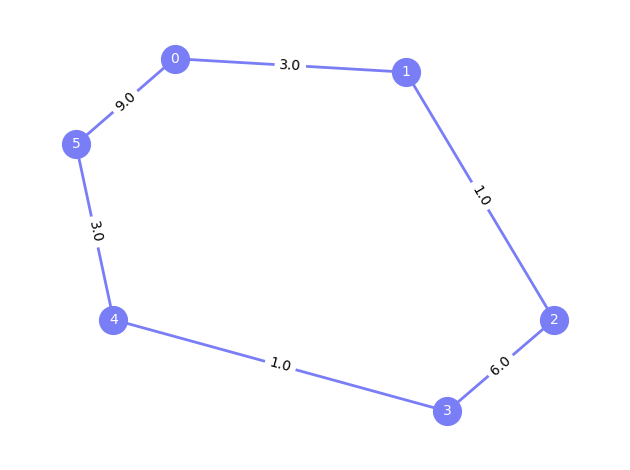

In [2]:
# Plot graph

G = nx.Graph()
G.add_edge(0, 1, weight=3.0)
G.add_edge(1, 2, weight=1.0)
G.add_edge(2, 3, weight=6.0)
G.add_edge(3, 4, weight=1.0)
G.add_edge(4, 5, weight=3.0)
G.add_edge(5, 0, weight=9.0)


pos = nx.spring_layout(G, seed=7)
edge_labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_nodes(G, pos, node_size=400, node_color="#797EF6")
nx.draw_networkx_edges(G, pos, width=2, edge_color="#797EF6")
nx.draw_networkx_labels(G, pos, font_size=10, font_family="sans-serif", font_color="w")
nx.draw_networkx_edge_labels(G, pos, edge_labels)


ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.show()


In [3]:
# Start (s) : 0
# Finish (f) : 3
# Qubits
# q0 : edge 0-1
# q1 : edge 1-2
# q2 : edge 2-3
# q3 : edge 3-4
# q4 : edge 4-5
# q5 : edge 5-0

# Paths :
# - q0-q1-q2
# - q5-q4-q3
weights_half = [3.0/2 , 1.0/2 , 6.0/2, 1.0/2 , 3.0/2 , 9.0/2 ]

# Basic cost Hamiltonian depending on edges' weights.
h_c = SparsePauliOp.from_list([("IIIIII", sum(weights_half)),
                               ("IIIIIZ", -weights_half[0]),
                               ("IIIIZI", -weights_half[1]),
                               ("IIIZII", -weights_half[2]),
                               ("IIZIII", -weights_half[3]),
                               ("IZIIII", -weights_half[4]),
                               ("ZIIIII", -weights_half[5])])

# condition to make sure we only "leave" once from the starting node.
h_s = SparsePauliOp.from_list([("IIIIIZ", -0.5),
                               ("ZIIIII", -0.5)])

# condition to make sure we only "arrive" once at the finishing node.
h_f = SparsePauliOp.from_list([("IIIZII", -0.5),
                               ("IIZIII", -0.5)])

# Sum of all prec and succ nodes of paths. (suivant - précédent)
h_1 = SparsePauliOp.from_list([("IIIIZI", -0.5),
                               ("IIIIIZ", +0.5)])

h_2 = SparsePauliOp.from_list([("IIIZII", -0.5),
                               ("IIIIZI", +0.5)])

h_4 = SparsePauliOp.from_list([("IIZIII", +0.5),
                               ("IZIIII", -0.5)])

h_5 = SparsePauliOp.from_list([("IZIIII", +0.5),
                               ("ZIIIII", -0.5)])

# Alpha shouldn't be too big to keep the energy spectrum of the hamiltonian usable with QAOA.
alpha = 25

# QUBO representation of Hamiltonian (cost function).
h = -h_c - alpha *((h_s)**2 + (h_f)**2 + (h_1)**2 + (h_2)**2+(h_4)**2+(h_5)**2)


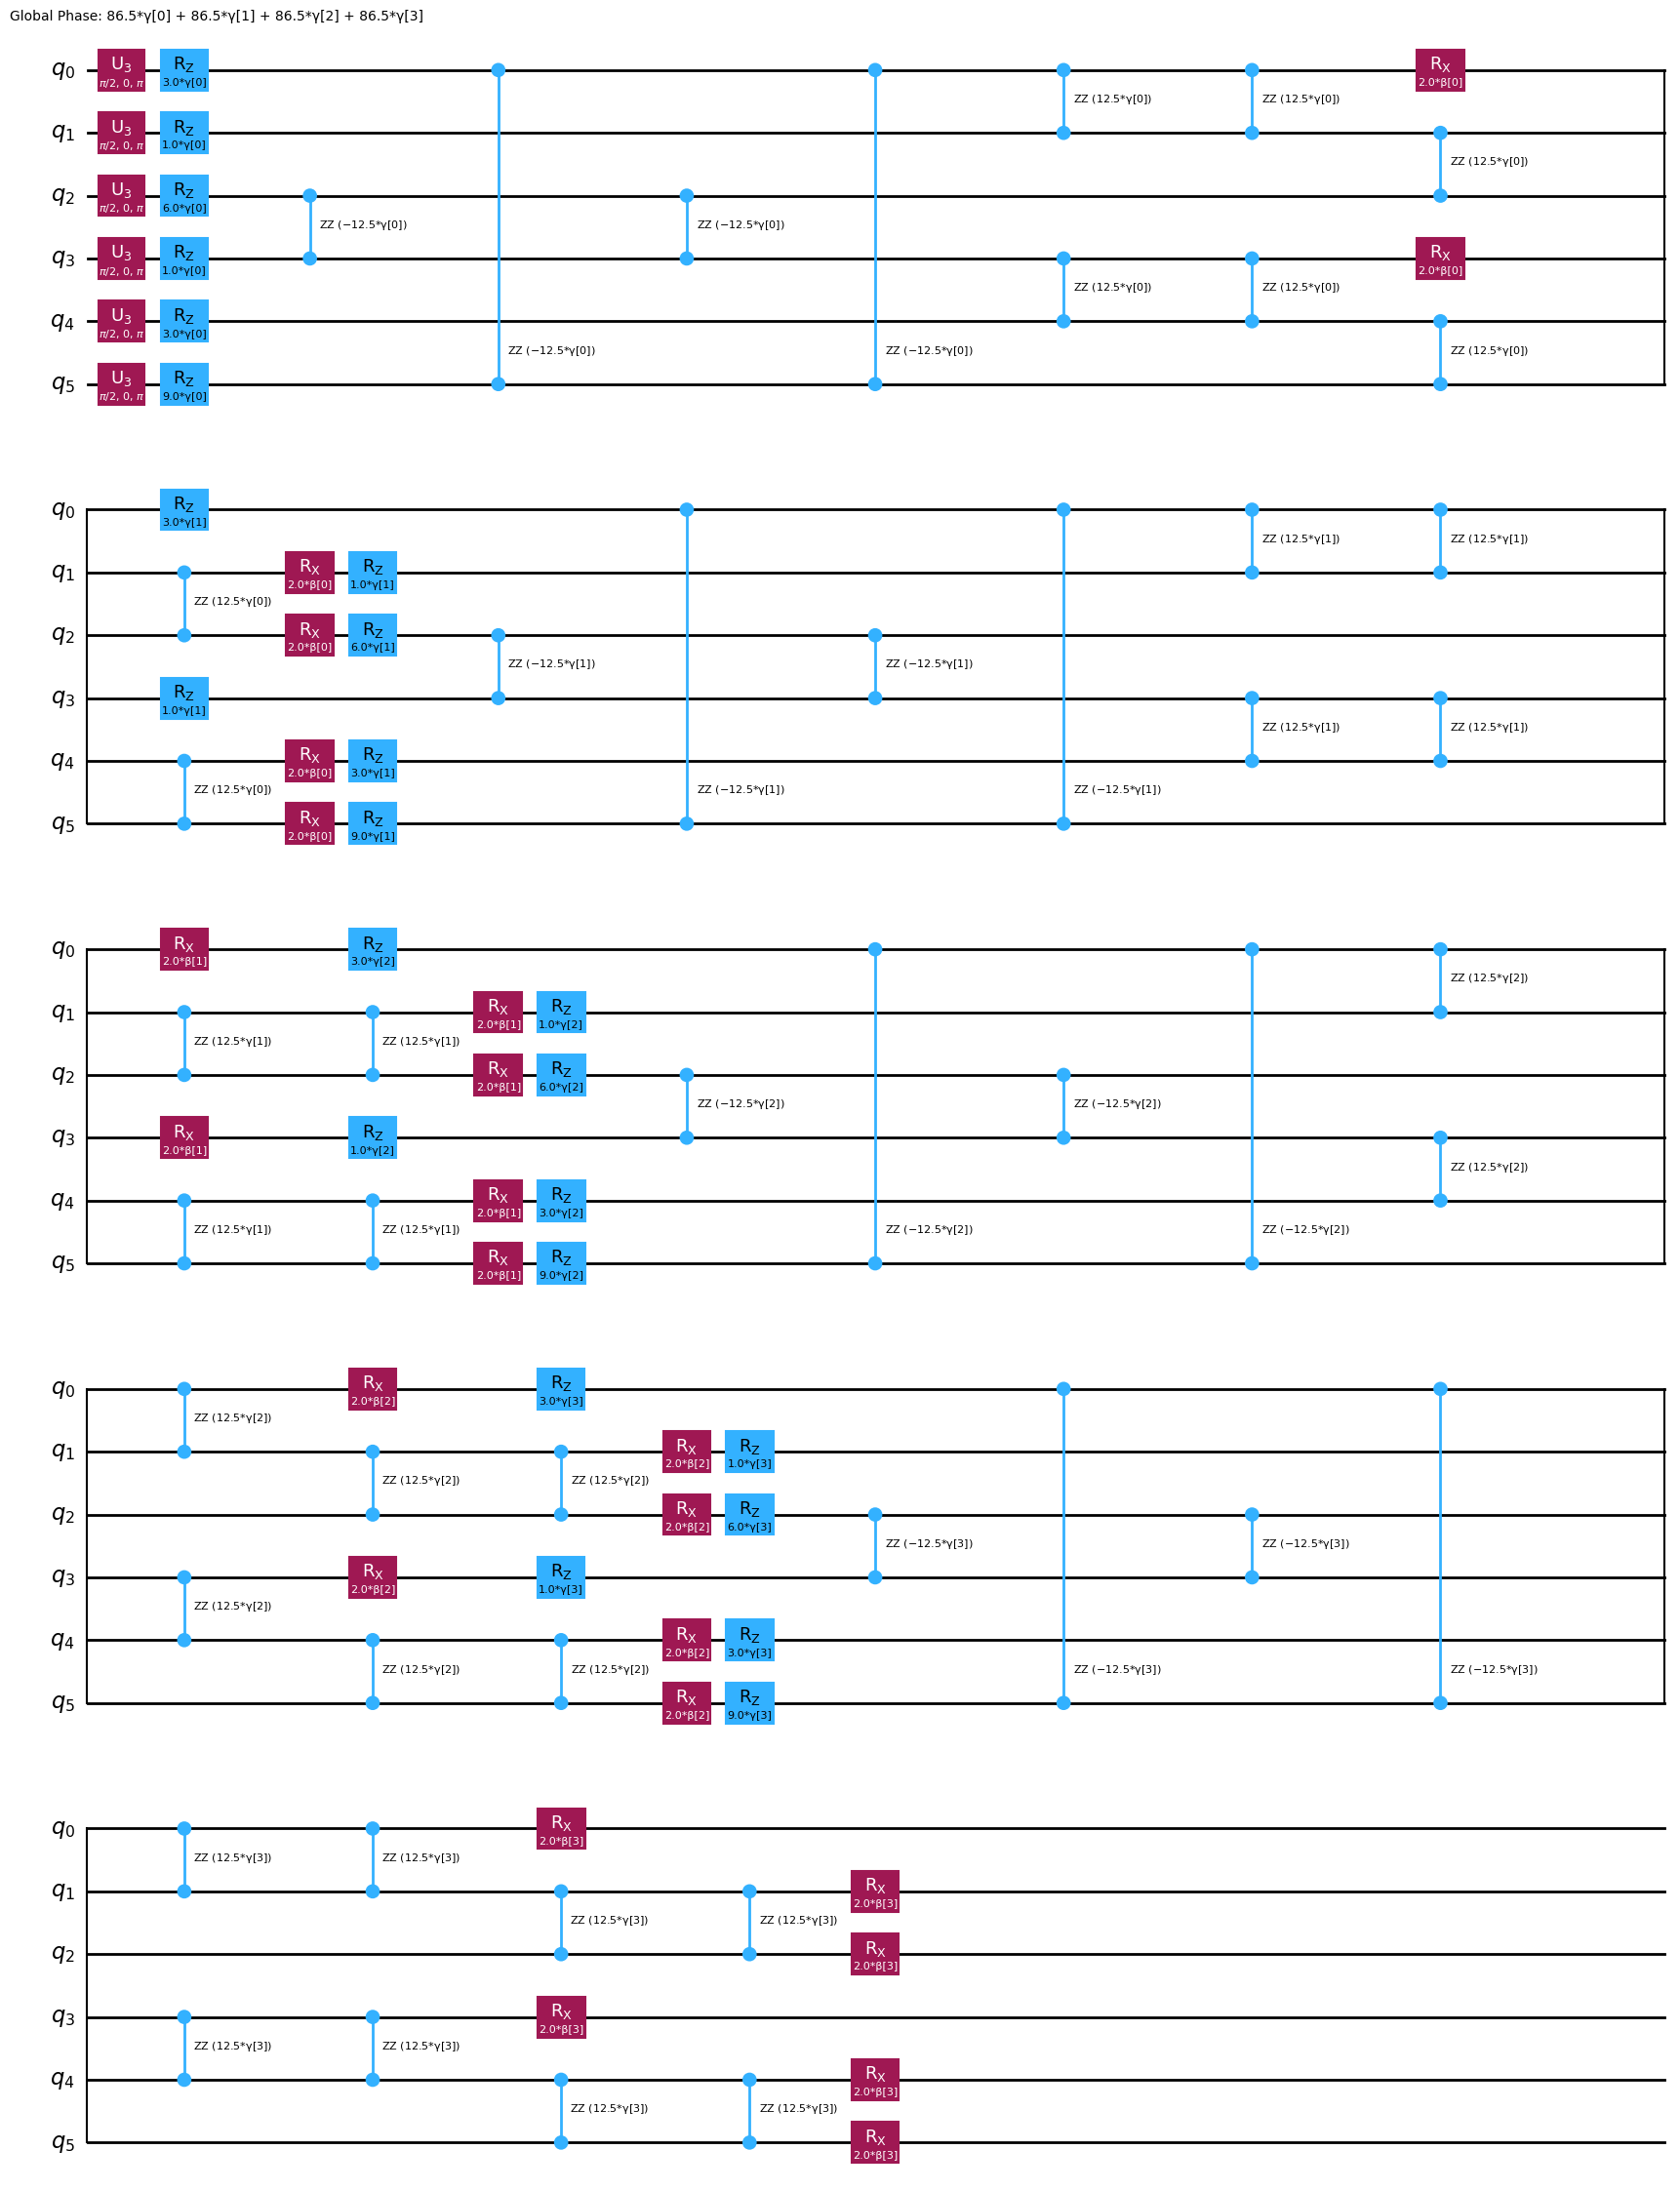

In [4]:
# Create QAOA circuit.
ansatz = QAOAAnsatz(h, reps=4)
ansatz.decompose(reps=3).draw(output="mpl", style="iqp")

In [5]:
# Run on local estimator and sampler. Fix seeds for results reproducibility.
estimator = Estimator(options={"shots": 1000000, "seed" : 42})
sampler = Sampler(options={"shots": 1000000, "seed" :42})

In [6]:
# Cost function for the minimizer.
# Returns the expectation value of circuit with Hamiltonian as an observable.
def cost_func(params, estimator, ansatz, hamiltonian):
    cost = estimator.run(ansatz, hamiltonian, parameter_values=params).result().values[0]
    return cost

In [7]:
# Generate starting point. Fixed to zeros for results reproducibility.
# x0 = 2 * np.pi * np.random.rand(ansatz.num_parameters)
x0 = np.zeros(ansatz.num_parameters)

res = minimize(cost_func, x0, args=(estimator, ansatz, h), method="COBYLA")

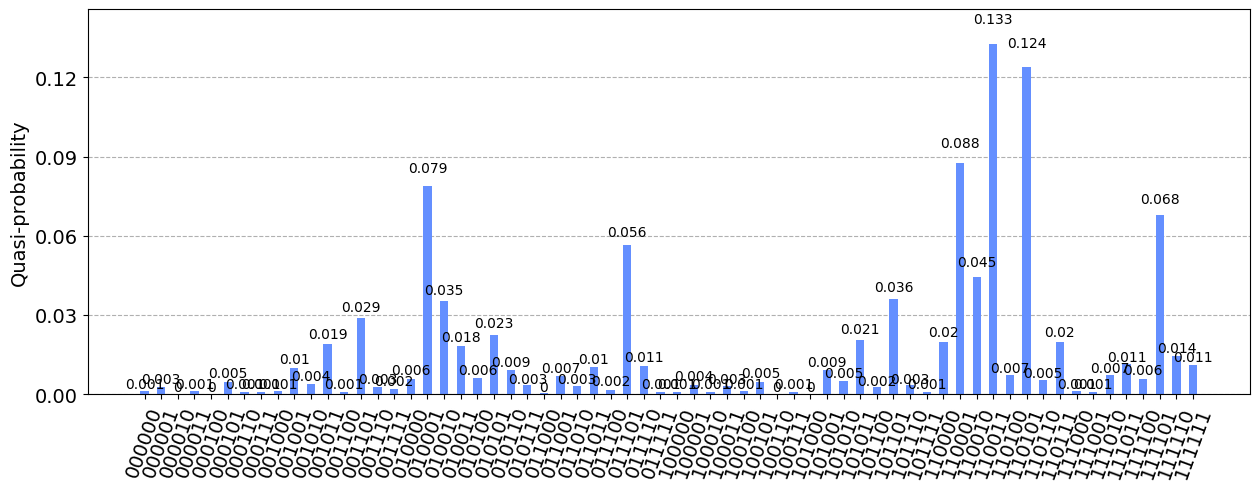

In [ ]:
# Get probability distribution associated with optimized parameters.
circ = ansatz.copy()
circ.measure_all()
dist = sampler.run(circ, res.x).result().quasi_dists[0]

plot_distribution(dist.binary_probabilities(), figsize=(15, 5))

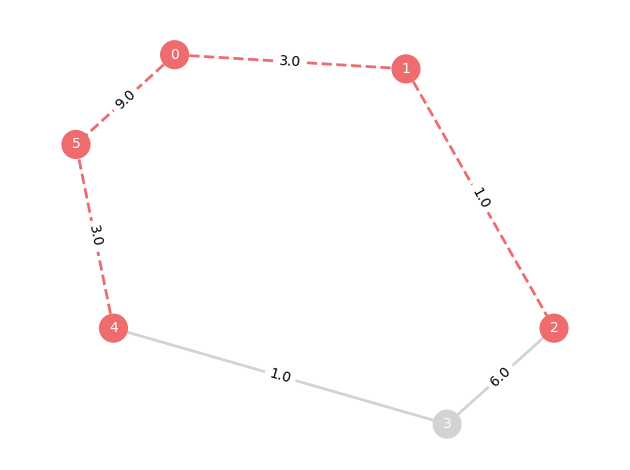

In [ ]:
# Display graph
bin_str = list(map(int, max(dist.binary_probabilities(), key=dist.binary_probabilities().get))) # type: ignore
bin_str.reverse()
bin_str.insert(1, bin_str.pop(-1))

pos = nx.spring_layout(G, seed=7)
edge_labels = nx.get_edge_attributes(G, "weight")

e_in  = [(u, v) for i, (u, v, d) in enumerate(G.edges(data=True)) if bin_str[i]]
e_out  = [(u, v) for i, (u, v, d) in enumerate(G.edges(data=True)) if not bin_str[i]]

color_map = np.array(["#D3D3D3"] * G.number_of_nodes())
color_map[list(sum(e_in, ()))] = "#EE6B6E"

nx.draw_networkx_nodes(G, pos, node_color=color_map, node_size=400)
nx.draw_networkx_edges(G, pos, edgelist=e_in, width=2, alpha=1, edge_color="#EE6B6E", style="dashed")
nx.draw_networkx_edges(G, pos, edgelist=e_out, width=2, edge_color="#D3D3D3")
nx.draw_networkx_edge_labels(G, pos, edge_labels)
nx.draw_networkx_labels(G, pos, font_size=10, font_family="sans-serif", font_color="w")

ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.show()